<a href="https://colab.research.google.com/github/Nivratti/Text_Classification/blob/master/Text_sentiment_analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text sentiment analysis on twitter US airline sentiment

# Connect Google Colab with Google Drive

In [159]:
from google.colab import drive

time: 1.31 ms


In [160]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 2.19 ms


## prevent-google-colab-from-disconnecting

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.

Solution:

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)

inser below code on console

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 1000);
```




# Execution Time

In [161]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 11.8 s


# Tensorflow with GPU -- For faster training

Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down
Next, we'll confirm that we can connect to the GPU with tensorflow:

In [162]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 14.1 ms


# Global vars

In [163]:
import os

# project folder on rive containing dataset, trained model and other files
DRIVE_PROJECT_BASE_DIR = "/content/gdrive/My Drive/deep_learning/text_sentiment_analysis/"

BASE_DATASET_DIR = os.path.join(
    DRIVE_PROJECT_BASE_DIR , "dataset"
)

input_csv_path = os.path.join(
    BASE_DATASET_DIR , "modified-twitter-us-airline-sentiment.csv"
)

time: 4.46 ms


#  utils

## Pandas utils

In [164]:
import pandas as pd
import os
import sys


def read_file_as_df(file__path):
    """
    read file data using pandas
    
    Arguments:
        file__path {string} -- File with path
    
    Returns:
        DataFrame -- pandas.core.frame.DataFrame
    """
    # file__path -- file with path(double underscore)
    if os.path.exists(file__path):
        file_name, extension = os.path.splitext(
            file__path
        )
        if extension in [".xlsx", ".xls"]:
            df = pd.read_excel(file__path)

        elif extension in [".csv"]:
            df = pd.read_csv(file__path)

        else:
            error_msg = f"""
                Error .. Unsupported file type
                {extension} to read_file_data()
            """
            print(error_msg)
            return False

        return df
    else:
        error_msg = f"""
            Error ... File not exists with
            path {file__path}
        """
        print(error_msg)
        sys.exit(error_msg)

def is_columns_exists(df, columns):
    """
    check is columns exists in dataframe
    
    Arguments:
        df {[type]} -- [description]
        columns {[type]} -- [description]
    """
    all_exists = True
    for column in columns:
        if column in df.columns:
            pass
        else:
            all_exists = False
            print(
                f"Column not exists in dataframe"
            )
    return all_exists

def keep_only_req_columns(df, columns):
    """
    Keeping only the necessary/required columns
    
    Arguments:
        df {[type]} -- [description]
        columns {list} -- ['text','sentiment']
    
    Returns:
        [type] -- [description]
    """
    return df[columns]

def filter_dataframe_rows(data_frame, row_rules):
    """
    filter dataframe row data
    data_frame (diffrent name taken for argument because it is mutable
    changable type)
    
    Arguments:
        data_frame {[type]} -- [description]
        row_rules {[type]} -- [description]
    
    Returns:
        dataFrame -- modified dataframe

    input examples:
        row_rules = [{
            "rule" : 'keep_row_if_column_text_not_equal_to',
            "column_name": "text",
            "text": "Neutral"
        },
        {
            "rule" : 'drop_if_column_value_null',
            "column_name": "text",
            "drop": True
        }]
    """
    for rule_item in row_rules:
        rule = rule_item.get("rule")
        if 'keep_row_if_column_text_not_equal_to' == rule:
            column = rule_item['column_name']
            text = rule_item['text']
            
            data_frame = data_frame[
                data_frame[column] != text
            ]
        
        if 'drop_if_column_value_null' == rule:
            column = rule_item['column_name']
            data_frame = data_frame[
                data_frame[column].str.strip().astype(bool)
            ]
            
    return data_frame

def generate_df_from_mongo_cursor(cursor, remove_id=False):
    """
    [summary]
    
    Arguments:
        cursor {[type]} -- Result of record fetching
    """
    df = pd.DataFrame(
        list(cursor)
    )
    if remove_id:
        # delete the _id
        del df['_id']
    return df


time: 44.9 ms


# Load Packages

In [165]:
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import numpy as np
%matplotlib inline


time: 5.35 ms


# Read dataset and view its metadata

## Read dataset

In [166]:
#load data as dataframe
dataset = read_file_as_df(input_csv_path)

time: 42.4 ms


## View info about dataframe

Number of rows and columns of data

In [167]:
print(f"Dataframe shape  : { dataset.shape }")

Dataframe shape  : (14640, 3)
time: 2.39 ms


Columns

In [168]:
print(f"Dataframe columns : \n{dataset.columns }")

Dataframe columns : 
Index(['Unnamed: 0', 'sentiment', 'text'], dtype='object')
time: 1.93 ms


Look at first 5 rows

In [169]:
dataset.head()

,Unnamed: 0,sentiment,text
0,0,neutral,@VirginAmerica What @dhepburn said.
1,1,positive,@VirginAmerica plus you've added commercials t...
2,2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,3,negative,@VirginAmerica it's really aggressive to blast...
4,4,negative,@VirginAmerica and it's a really big bad thing...


time: 25.5 ms


rename columns

In [170]:
# dataset = dataset.rename(columns={"airline_sentiment": "sentiment"})
# dataset.head()

time: 1.17 ms


Checking whether there is any null values (for text and sentiment column)

In [171]:
dataset.isnull().sum()

Unnamed: 0    0
sentiment     0
text          0
dtype: int64

time: 13.9 ms


drop null review rows if exists

In [172]:
# # drop null review rows
# dataset = dataset[~dataset['text'].isnull()]

# # after dropping null
# dataset.isnull().sum()

time: 559 µs


view data per class

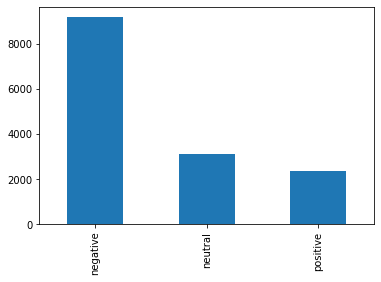

time: 166 ms


In [173]:
dataset["sentiment"].value_counts().plot.bar()

Keep only required columns

In [174]:
dataset = keep_only_req_columns(dataset, ["sentiment", "text"])

time: 4.51 ms


In [175]:
dataset.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


time: 17.6 ms


# Text Preprocessing

The first thing I'm going to do to process the text is to lowercase everything and then remove non-word characters. I replace these with spaces since most are going to be punctuation. Then I'm going to just remove any other characters (like letters with accents). It could be better to replace some of these with regular ascii characters but I'm just going to ignore that here. It also turns out if you look at the counts of the different characters that there are very few unusual characters in this corpus.

## Preprocessor

Remove:
* URLs
* Hashtags
* Mentions
* Reserved words (RT, FAV)
* Emojis
* Smileys

In [176]:
!pip install tweet-preprocessor

time: 4.66 s


In [177]:
import preprocessor as p
print(p.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor'))
print(p.clean("@peter I really love that shirt at #Macy. http://bet.ly//WjdiW4"))
# p.clean("Have questions about asteroid 1998 OR2, comet Borisov, or comet Atlas? Want to know more about these cosmic objects zipping through our solar system? Flushed faceComet Join us in an hour at 4pm ET on @reddit to chat with NASA scientists and experts about them! https://redd.it/g9o4yp")

Preprocessor is
I really love that shirt at .
time: 4.77 ms


## Removing stopwords

Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

```
Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.
```

In [178]:
from gensim.parsing.preprocessing import remove_stopwords

remove_stopwords("Better late than never, but better never late.")

'Better late never, better late.'

time: 4.17 ms


## Lemmatization

Lemmatization, is an organized & step-by-step procedure of obtaining the root form of the word. It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [179]:
import spacy
from pprint import pprint

spacy_nlp = spacy.load('en', disable=['parser', 'ner'])

def do_lemmatization(sentence):
  doc = spacy_nlp(sentence)

  lemmas = []
  for token in doc:
      if token.lemma_ != "-PRON-":
        lemmas.append(token.lemma_)

  return " ".join(lemmas)

time: 513 ms


In [180]:
sentence = """Following mice attacks, caring farmers were marching to Delhi for better living conditions. 
Delhi police on Tuesday fired water cannons and teargas shells at protesting farmers as they tried to 
break barricades with their cars, automobiles and tractors."""

print(do_lemmatization(sentence))

follow mice attack , care farmer be march to Delhi for well living condition . 
 Delhi police on Tuesday fire water cannon and teargas shell at protest farmer as try to 
 break barricade with car , automobile and tractor .
time: 17.2 ms


## Final Normalization

In [181]:
import re

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def normalize_text(text):
    # cleaned_text = p.clean(text) # tweet preprocessor
    # text_without_stopwords = remove_stopwords(cleaned_text)
    # text_lemmatization = do_lemmatization(text_without_stopwords)
    
    # lower = text_lemmatization.lower()
    lower = text.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii

time: 9.33 ms


In [182]:
dataset['text'] = dataset['text'].apply(normalize_text)

time: 43.9 s


# Extract texts and labels from dataframe

In [266]:
texts = dataset["text"].values.tolist()
labels = dataset["sentiment"].values.tolist()

import numpy as np
labels = np.array(labels)

time: 8.1 ms


# Resampling Imbalanced datasets

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://medium.com/@er.archiejain/balance-the-imbalanced-datasets-smote-810c2f13ce16

## under sampling

In [215]:
# from imblearn.under_sampling import RandomUnderSampler
# import numpy as np

# X = np.array(texts)
# y = labels

# # # make 2 da array first
# X = X.reshape(-1, 1)

# # random under sampling
# rus = RandomUnderSampler()
# X_rus, y_rus = rus.fit_sample(X, y)

# # # make 1D again
# X_rus = X_rus.flatten()

time: 31.6 ms


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


negative    2363
positive    2363
neutral     2363
dtype: int64

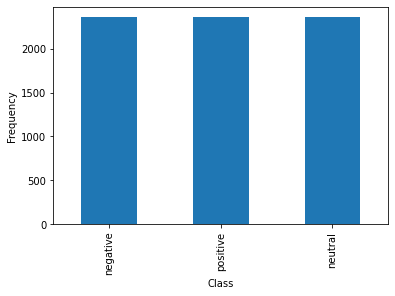

time: 167 ms


In [216]:
# import pandas as pd
# import matplotlib.pyplot as plt

# pd.value_counts(y_rus).plot.bar()

# plt.xlabel('Class')
# plt.ylabel('Frequency')
# pd.value_counts(y_rus)

## Over sampling

In [268]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

X = np.array(texts)
y = labels

# # make 2 da array first
X = X.reshape(-1, 1)

# random under sampling
rus = RandomOverSampler()
X_ros, y_ros = rus.fit_sample(X, y)

# # make 1D again
X_ros = X_ros.flatten()

time: 53.4 ms


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


negative    9178
positive    9178
neutral     9178
dtype: int64

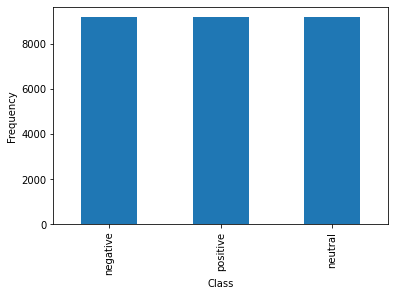

time: 175 ms


In [269]:
import pandas as pd
import matplotlib.pyplot as plt

pd.value_counts(y_ros).plot.bar()

plt.xlabel('Class')
plt.ylabel('Frequency')
pd.value_counts(y_ros)

## Assign Back

In [270]:
# assign back
# texts = X_rus.tolist()
# labels = y_rus


texts = X_ros.tolist()
labels = y_ros

time: 14.6 ms


# Encode labels (String to int)

In [271]:

# Keras expects an integer vector from 0 to num_classes. As it's stated in the docs:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
encoded_labels = labelencoder.fit_transform(labels)

# Print shapes
print("Shape of encoded_labels: {}".format(encoded_labels.shape))


Shape of encoded_labels: (27534,)
time: 10.1 ms


In [272]:
num_classes = len(np.unique(encoded_labels))
print("Total classes: {}".format(num_classes))

Total classes: 3
time: 9.68 ms


# Train/Validation Split
Now I'm going to set aside 20% of the training set for validation.

In [273]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, encoded_labels, random_state=57692, test_size=0.2
)

time: 18.5 ms


In [274]:
print("Shape of train_labels: {}".format(train_labels.shape))
print("length of train_texts: {}".format(len(train_texts)))

print("Shape of val_labels: {}".format(val_labels.shape))
print("length of val_texts: {}".format(len(val_texts)))

Shape of train_labels: (22027,)
length of train_texts: 22027
Shape of val_labels: (5507,)
length of val_texts: 5507
time: 4.45 ms


viewing top 5 labels and first training text.

In [275]:
print(train_labels[:5])
print(train_texts[:1])

[2 1 0 2 2]
['flight attendant super helpful find bag left flight today   excellent customer service   name fit  ']
time: 2.44 ms


# Tokenization

Now I will just run a Tokenizer using the top 12000 words as features.

In [276]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)

train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)

time: 717 ms


# Padding Sequences
In order to use batches effectively, I'm going to need to take my sequences and turn them into sequences of the same length. I'm just going to make everything here the length of the longest sentence in the training set. I'm not dealing with this here, but it may be advantageous to have variable lengths so that each batch contains sentences of similar lengths. This might help mitigate issues that arise from having too many padded elements in a sequence.


In [277]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)

train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)
# test_texts = pad_sequences(test_texts, maxlen=MAX_LENGTH)

time: 117 ms


# Save Tokenizer

In [278]:
import pickle

# saving
tokenizer_info = {
    "tokenizer"   : tokenizer,
    "MAX_LENGTH"  : MAX_LENGTH,
    "MAX_FEATURES": MAX_FEATURES,
}
with open('tokenizer_info.pickle', 'wb') as handle:
    pickle.dump(tokenizer_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

time: 10.7 ms


In [279]:
# make some space
del tokenizer

import gc

print(f"total objects in memory --{gc.get_count()}")

# collecting memory
gc.collect()
print(f"After garbage collecor- objects in memory --{gc.get_count()}")

total objects in memory --(163, 8, 19)
After garbage collecor- objects in memory --(24, 0, 0)
time: 340 ms


# convert to categorical data

In [280]:
from keras.utils import to_categorical

train_y = to_categorical(train_labels, num_classes=num_classes, dtype='float32')
val_y = to_categorical(val_labels, num_classes=num_classes, dtype='float32')

# Print shapes
print("Shape of train_y: {}".format(train_y.shape))
print("Shape of val_y: {}".format(val_y.shape))

Shape of train_y: (22027, 3)
Shape of val_y: (5507, 3)
time: 6.04 ms


view single record

In [281]:
print(train_y[0])

[0. 0. 1.]
time: 2.34 ms


# Deep learning Models

In [282]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding, CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

time: 9.86 ms


## Utilities

### Plotting accuracy and loss graph

In [283]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
  axes = plt.axes()
  axes.set_ylim([0, 1])

  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  axes = plt.axes()
  # axes.set_ylim([0, 1])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

time: 18.6 ms


## LSTM

In [284]:
embed_dim = 128

model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH, mask_zero=True))
model_LSTM.add(LSTM(128,dropout=0.2,return_sequences=True))
model_LSTM.add(LSTM(64,dropout=0.4,return_sequences=True))
model_LSTM.add(LSTM(32,dropout=0.5,return_sequences=False))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['acc'])
model_LSTM.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 26, 128)           1536000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 26, 128)           131584    
_________________________________________________________________
lstm_20 (LSTM)               (None, 26, 64)            49408     
_________________________________________________________________
lstm_21 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total params: 1,729,507
Trainable params: 1,729,507
Non-trainable params: 0
_________________________________________________________________
time: 2.1 s


### Callbacks

In [285]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "lstm_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 6.21 ms


### Train

In [286]:
# Train model
epochs = 250
batch_size = 2048 # 64 # use more if gpu available - for faster processing 
history = model_LSTM.fit(
    train_texts, train_y, 
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, shuffle=True,
    callbacks=cb_list,
)

Train on 22027 samples, validate on 5507 samples
Epoch 1/250
22027/22027 [==============================] - 6s 269us/step - loss: 1.0860 - acc: 0.3381 - val_loss: 1.0649 - val_acc: 0.3519

Epoch 00001: val_loss improved from inf to 1.06488, saving model to lstm_model.best.hdf5
Epoch 2/250
22027/22027 [==============================] - 3s 135us/step - loss: 0.9964 - acc: 0.5039 - val_loss: 0.9004 - val_acc: 0.6125

Epoch 00002: val_loss improved from 1.06488 to 0.90044, saving model to lstm_model.best.hdf5
Epoch 3/250
22027/22027 [==============================] - 3s 123us/step - loss: 0.8087 - acc: 0.6941 - val_loss: 0.7398 - val_acc: 0.7391

Epoch 00003: val_loss improved from 0.90044 to 0.73985, saving model to lstm_model.best.hdf5
Epoch 4/250
22027/22027 [==============================] - 3s 123us/step - loss: 0.6417 - acc: 0.7824 - val_loss: 0.6373 - val_acc: 0.7725

Epoch 00004: val_loss improved from 0.73985 to 0.63734, saving model to lstm_model.best.hdf5
Epoch 5/250
22027/22027

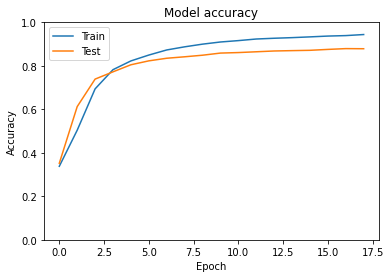

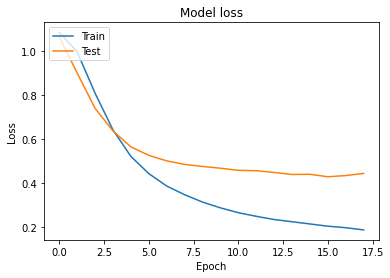

time: 351 ms


In [287]:
plot_accuracy_loss(history)

## Convolutional Neural Net Model

In [288]:
# set parameters:
filters = 250
kernel_size = 3
hidden_dims = 250

model_cnn = Sequential()

model_cnn.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['acc'])

print(model_cnn.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 26, 128)           1536000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 26, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 250)           96250     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_10 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_9 (Activation)    (None, 250)             

### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [289]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "cnn_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 5.24 ms


### Start training

In [290]:
# Train model
epochs = 25
batch_size = 2048 # 64 # use more if gpu available - for faster processing 
history = model_cnn.fit(
    train_texts, train_y,
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size,
    verbose=1,shuffle=True,
    callbacks=cb_list,
    
)

Train on 22027 samples, validate on 5507 samples
Epoch 1/25
22027/22027 [==============================] - 4s 160us/step - loss: 1.0718 - acc: 0.4532 - val_loss: 1.0254 - val_acc: 0.5072

Epoch 00001: val_loss improved from inf to 1.02536, saving model to cnn_model.best.hdf5
Epoch 2/25
22027/22027 [==============================] - 1s 25us/step - loss: 0.9354 - acc: 0.6156 - val_loss: 0.8122 - val_acc: 0.7075

Epoch 00002: val_loss improved from 1.02536 to 0.81222, saving model to cnn_model.best.hdf5
Epoch 3/25
22027/22027 [==============================] - 1s 23us/step - loss: 0.6910 - acc: 0.7455 - val_loss: 0.6051 - val_acc: 0.7672

Epoch 00003: val_loss improved from 0.81222 to 0.60508, saving model to cnn_model.best.hdf5
Epoch 4/25
22027/22027 [==============================] - 1s 24us/step - loss: 0.5031 - acc: 0.8093 - val_loss: 0.5093 - val_acc: 0.8097

Epoch 00004: val_loss improved from 0.60508 to 0.50926, saving model to cnn_model.best.hdf5
Epoch 5/25
22027/22027 [==========

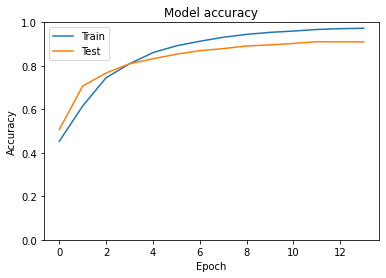

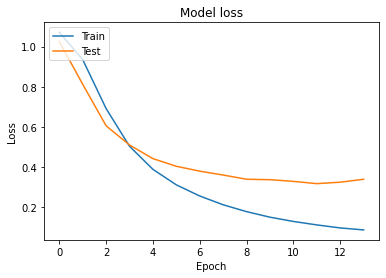

time: 375 ms


In [291]:
plot_accuracy_loss(history)

## GRU

In [292]:
def build_gru_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    return model
    
gru_model = build_gru_model()

time: 313 ms


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [293]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 4.58 ms


### Train

In [294]:
epochs = 25
batch_size = 2048 # 128 # use more if gpu available - for faster processing 

history = gru_model.fit(
    train_texts, 
    train_y, 
    validation_data=(val_texts, val_y),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=cb_list,
)

Train on 22027 samples, validate on 5507 samples
Epoch 1/25
20480/22027 [==========================>...] - ETA: 0s - loss: 1.0874 - acc: 0.4422
Epoch 00001: val_loss improved from inf to 1.04939, saving model to gru_model.best.hdf5
22027/22027 [==============================] - 16s 740us/sample - loss: 1.0852 - acc: 0.4495 - val_loss: 1.0494 - val_acc: 0.5097
Epoch 2/25
20480/22027 [==========================>...] - ETA: 0s - loss: 1.0060 - acc: 0.5413
Epoch 00002: val_loss improved from 1.04939 to 0.90191, saving model to gru_model.best.hdf5
22027/22027 [==============================] - 1s 45us/sample - loss: 0.9994 - acc: 0.5509 - val_loss: 0.9019 - val_acc: 0.6415
Epoch 3/25
20480/22027 [==========================>...] - ETA: 0s - loss: 0.7350 - acc: 0.7316
Epoch 00003: val_loss improved from 0.90191 to 0.59947, saving model to gru_model.best.hdf5
22027/22027 [==============================] - 1s 40us/sample - loss: 0.7241 - acc: 0.7344 - val_loss: 0.5995 - val_acc: 0.7605
Epoch 4/

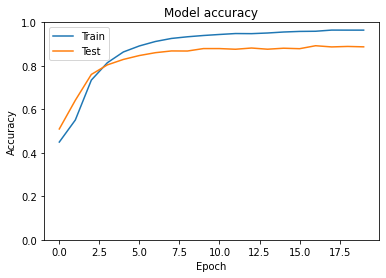

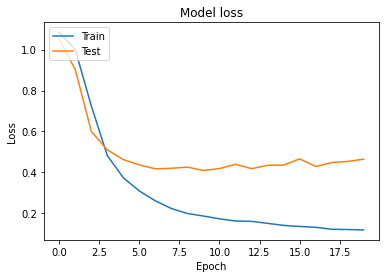

time: 360 ms


In [295]:
plot_accuracy_loss(history)

## Bidirectional-GRU

In [296]:
embed_dim = 64

def build_bidirectional_gru():
	model = Sequential()
	model.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
	model.add(SpatialDropout1D(0.25))
	model.add(Bidirectional(GRU(64,dropout=0.4, return_sequences = True)))
	model.add(Bidirectional(GRU(32,dropout=0.5, return_sequences = False)))
	model.add(Dense(num_classes, activation='softmax'))
	model.compile(
		loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), 
		metrics = ['acc']
	)
	return model
	
bidirectional_gru_model = build_bidirectional_gru()

time: 2.45 s


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [297]:
# Adding the callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "bidirectional_gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 3.62 ms


### Train

In [298]:
epochs = 25
batch_size = 2048 # 128 # use more if gpu available - for faster processing 

history = bidirectional_gru_model.fit(
    train_texts, 
    train_y, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_texts, val_y),
    callbacks=cb_list,
)

Train on 22027 samples, validate on 5507 samples
Epoch 1/25
22027/22027 [==============================] - 6s 279us/step - loss: 1.0883 - acc: 0.4090 - val_loss: 1.0688 - val_acc: 0.5698

Epoch 00001: val_loss improved from inf to 1.06880, saving model to bidirectional_gru_model.best.hdf5
Epoch 2/25
22027/22027 [==============================] - 3s 119us/step - loss: 1.0310 - acc: 0.5508 - val_loss: 0.9667 - val_acc: 0.5894

Epoch 00002: val_loss improved from 1.06880 to 0.96671, saving model to bidirectional_gru_model.best.hdf5
Epoch 3/25
22027/22027 [==============================] - 3s 114us/step - loss: 0.9015 - acc: 0.6094 - val_loss: 0.8083 - val_acc: 0.6715

Epoch 00003: val_loss improved from 0.96671 to 0.80833, saving model to bidirectional_gru_model.best.hdf5
Epoch 4/25
22027/22027 [==============================] - 3s 115us/step - loss: 0.7053 - acc: 0.7156 - val_loss: 0.6261 - val_acc: 0.7467

Epoch 00004: val_loss improved from 0.80833 to 0.62612, saving model to bidirecti

### Visualize

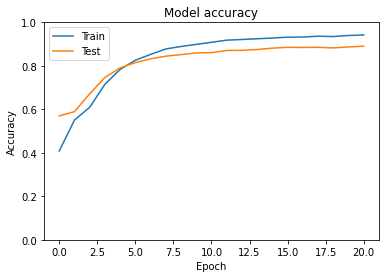

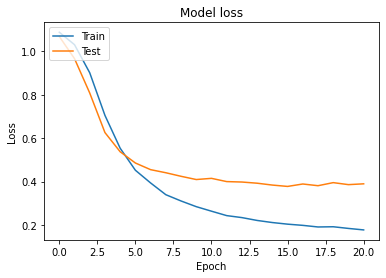

time: 356 ms


In [299]:
plot_accuracy_loss(history)

# Machine Learning

Accuracy : 0.362992554930089


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


NameError: ignored

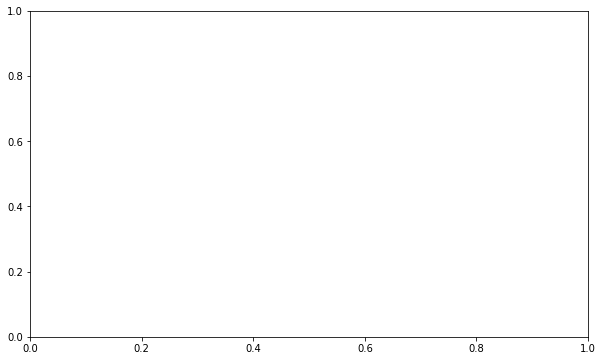

time: 7.29 s


In [300]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

model = LinearSVC()
model.fit(train_texts, train_labels)
y_pred = model.predict(val_texts)

print(f"Accuracy : {accuracy_score(val_labels, y_pred)}")

conf_mat = confusion_matrix(val_labels, y_pred)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.title('Confusion_matrix', y=1.05, size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()